# Data mining project.
##### Sean Gies - s4783670
##### Piotr Leszmann - s4771826

Data set: https://www.kaggle.com/uciml/breast-cancer-wisconsin-data/data

Will use sklearn to make a decision tree to classify cancers as malignant or benign.   
We will then also apply either an SVM or kNN algorithm for classification.

Useful information on decision tree implementation: http://scikit-learn.org/stable/modules/tree.html

We will fit decision trees using the scikitlearn classifier
`sklearn.tree.DecisionTreeClassifier`. As a splitting criterion, the function uses
one of the following two impurity measures:

\begin{equation} \textrm{gdi}(t) = -\sum_{i=1}^C p(i|t)^2 \quad \text{       equivalent to Gini(t)} \end{equation}   

\begin{equation}
\textrm{deviance}(t) = -2\sum_{i=1}^C p(i|t) \log p(i|t) \quad \text{equivalent to Entropy(t)} 
\end{equation}

## Part 1 Preprocessing

We know the class distribution: 212 malignant, 357 benign.

First we import and corretly sort the data for use in the decision tree:

In [206]:
import numpy as np
from scipy.io import loadmat          
import pandas as pd
from pandas import DataFrame


#Read data file from csv.
raw_data = pd.read_csv("Data/data.csv")
#print(raw_data.head(3))
print(raw_data.axes)

#column_names = [i for i in raw_data.keys()]    
#for column in column_names:
#   raw_data = raw_data[pd.to_numeric(raw_data[column],errors='coerce').notnull()]

#Create X,y data sets for decision tree. y - class label, X - data.
y = raw_data['diagnosis']
X_raw = raw_data.drop(['diagnosis'],1)
X_raw = X_raw.drop(['id'],1)
X_raw = X_raw.drop(['Unnamed: 32'],1)
#print(X)

attributeNames = [i for i in raw_data.keys()][2:32]
classNames = ['Malignant','Benign']

#===============================================================================
#Here we create a list of lists for X in the form of [[col1], [col2], ...]. 
#X_list = []
#for i in attributeNames:
#    X_list.append(X[i].as_matrix())  
X_list = X_raw.as_matrix().transpose()

#Here we create a list of lists for y. 
y_list = []
for j in raw_data['diagnosis']:
    y_list.append([j])


#We convert the y_list from text to integers. ie. M = 0, B = 1.
for i in range(0,len(y_list)):
    if(y_list[i] == ['M']):
        y_list[i] = 0
    else:
        y_list[i] = 1
    
    
#Question; should the X_data be [[row1], [row2], ...], or [[col1], [col2], ...] it works as the [[row]]
X_list = X_raw.as_matrix()

[RangeIndex(start=0, stop=569, step=1), Index([u'id', u'diagnosis', u'radius_mean', u'texture_mean', u'perimeter_mean',
       u'area_mean', u'smoothness_mean', u'compactness_mean',
       u'concavity_mean', u'concave points_mean', u'symmetry_mean',
       u'fractal_dimension_mean', u'radius_se', u'texture_se', u'perimeter_se',
       u'area_se', u'smoothness_se', u'compactness_se', u'concavity_se',
       u'concave points_se', u'symmetry_se', u'fractal_dimension_se',
       u'radius_worst', u'texture_worst', u'perimeter_worst', u'area_worst',
       u'smoothness_worst', u'compactness_worst', u'concavity_worst',
       u'concave points_worst', u'symmetry_worst', u'fractal_dimension_worst',
       u'Unnamed: 32'],
      dtype='object')]


## 1.2
Now we will run the decision tree with our data.

      |->2  Benign
      |
   |->1 then if concave points_worst =< 0.135800004005: go to 2, else go to 3
   |  |
   |  |->3  Malignant
   |
if radius_worst =< 16.7950000763: go to 1, else go to 4
   |
   |  |->5  Benign
   |  |
   |->4 else if texture_mean =< 16.1100006104: go to 5, else go to 6
      |
      |->6  Malignant
<-------->
Tree Depth:  2
Correct classification percentage: 0.942003514938


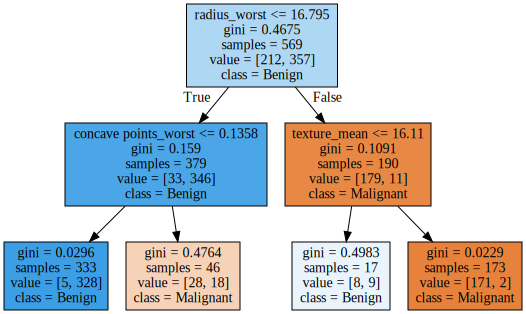

In [207]:
from sklearn import tree
from treeprint import tree_print
from sklearn.tree import export_graphviz
import graphviz

clf = tree.DecisionTreeClassifier(criterion = 'gini', min_samples_split = 2, max_depth = 2)
clf = clf.fit(X_list,y_list)

tree_print(clf, attributeNames, classNames)

print('Correct classification percentage: ' + str(clf.score(X_list, y_list, sample_weight=None)))

dot_data = export_graphviz(clf, out_file=None, \
                           feature_names = attributeNames, class_names = classNames, \
                          filled = True, impurity = True)
graph = graphviz.Source(dot_data)
#graph.render("cancer_tree")
graph

## 1.3
Above we made a decision tree using all our data. Now we are going to use cross-validation to create test and training sets. We then use these to see if our decision tree has an optimal depth. 
We also made a quick confusion matrix for our data.


depth - correct classification % train - correct classification % test
2 - 0.946009389671 - 0.916083916084
3 - 0.971830985915 - 0.951048951049
4 - 0.995305164319 - 0.944055944056
5 - 0.995305164319 - 0.937062937063
6 - 0.99765258216 - 0.937062937063
7 - 1.0 - 0.937062937063
8 - 1.0 - 0.951048951049
9 - 1.0 - 0.944055944056
10 - 1.0 - 0.951048951049
11 - 1.0 - 0.951048951049
12 - 1.0 - 0.951048951049


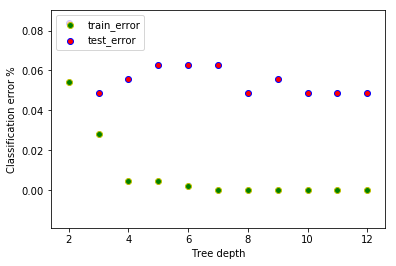

Lowest train_error: 0.951048951049


,Predicted Malignant,Predicted Benign
True Malignant,52,2
True Benign,5,84


In [208]:
from sklearn import model_selection,tree
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

X_train,X_test,y_train,y_test = train_test_split(X_list,y_list,test_size=0.25,random_state=42)

train_error = []
test_error = []

depth = 13

print("depth - correct classification % train - correct classification % test")
for i in range(2,depth):
    clf = tree.DecisionTreeClassifier(criterion = 'gini', max_depth = i, min_samples_split= 2)
    clf = clf.fit(X_train,y_train)
    predictions = clf.predict(X_test)
    x = clf.score(X_train,y_train,sample_weight = None)
    y = clf.score(X_test, y_test, sample_weight = None)
    train_error.append(1-x)
    test_error.append(1-y)
    print(str(i) + ' - ' + str(x) + ' - ' + str(y))
    
plt.scatter(range(2,depth), train_error, c = 'g', edgecolors = 'y', marker = 'o', label="train_error")
plt.scatter(range(2,depth), test_error, c = 'r', edgecolors = 'b', marker = 'o', label="test_error")
plt.xlabel("Tree depth")
plt.ylabel("Classification error %")
plt.legend(loc=2)
plt.show()

print "Lowest train_error: " + str(1 - np.min(test_error))
#Something wrong here with the titles i think.
pd.DataFrame(
    confusion_matrix(y_test, predictions),
    columns=['Predicted Malignant', 'Predicted Benign'],
    index=['True Malignant', 'True Benign']
)

## 1.4
Below we used Kfold cross-validation

Number of partitions: 16
Correct classification rate  -  depth
0.929811507937 - 2
0.919345238095 - 3
0.940376984127 - 4
0.940327380952 - 5
0.940376984127 - 6
0.938640873016 - 7
0.938591269841 - 8
0.931498015873 - 9
0.93685515873 - 10
0.934970238095 - 11
0.933234126984 - 12
0.931448412698 - 13
0.93869047619 - 14
0.93869047619 - 15
0.928025793651 - 16
0.92619047619 - 17
0.935119047619 - 18
0.931597222222 - 19
0.927926587302 - 20
max0.940376984127 min 0.919345238095


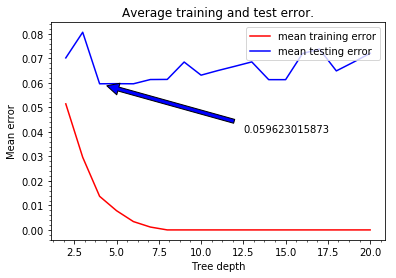

minimum test error: 0.059623015873 at tree depth 2


In [209]:
from sklearn.model_selection import KFold
import numpy as np

K = 16
kf = KFold(n_splits = K)


mean_train_error = []
mean_test_error = []

y_list_for_kfold = raw_data['diagnosis'].as_matrix()
    
for i in range(2,21):
    train_error = []
    test_error = []
    for train, test in kf.split(X_list):
        X_train,y_train,X_test,y_test = X_list[train], y_list_for_kfold[train], X_list[test], y_list_for_kfold[test]
        clf = tree.DecisionTreeClassifier(criterion = 'gini', max_depth = i, min_samples_split = 2)
        clf = clf.fit(X_train,y_train)
        train_error.append(1-clf.score(X_train,y_train))
        test_error.append(1-clf.score(X_test,y_test))
        
    mean_train_error.append(np.mean(train_error))
    mean_test_error.append(np.mean(test_error))

print "Number of partitions: " + str(K)
print "Correct classification rate  -  depth"
for i in range(0,len(mean_test_error)):
    print str(1-mean_test_error[i]) + " - " + str(i+2)
 
print "max" +str(1-np.min(mean_test_error)) + " min " + str(1 - np.max(mean_test_error))
plt.plot(range(2,21), mean_train_error, '-r', label = 'mean training error')
plt.plot(range(2,21), mean_test_error, '-b', label = 'mean testing error')
plt.minorticks_on()
plt.xlabel('Tree depth')
plt.ylabel('Mean error')
plt.legend(loc="upper right")
plt.title('Average training and test error.')
plt.annotate(str(np.min(mean_test_error)), xy=((mean_test_error.index(np.min(mean_test_error))+2), np.min(mean_test_error)), xytext=(12.5, 0.04),arrowprops=dict(facecolor='blue', shrink=0.05),)
plt.show()


print "minimum test error: " + str(np.min(mean_test_error)) + " at tree depth " + str(mean_test_error.index(np.min(mean_test_error)))

    

## 1.5 

Here we try to plot the decision tree surface for different pairwise features.  
Mainly we try to plot the means-feature values against each other. This is a totel of 81 graphs.(we leave out [i,i] pairs)

First we just plot the pair-wise attributes in scatter plots. This lets us see which attributes actually have a correlation between each other. eg. We can see that an increase in texture_mean has no effect on fractal_dimension_mean.

In [210]:
#This code adds all possible pairwise attributes into a list. 

graph_pair = []

#Adds all the means to the graph_pair list.
for i in range(0,10):
    #print(attributeNames[i])
    for j in range(1,10):
        if i != j:
            graph_pair.append([i,j])
        
print len(graph_pair)
print graph_pair
 
#Here we print all pair-wise graphs between our attributes.
count = 0
for i in enumerate(graph_pair):
    plt.plot(X_list[:,i[1][0]], X_list[:,i[1][1]], 'bx')
    plt.axis('equal')
    plt.xlabel(attributeNames[i[1][0]])
    plt.ylabel(attributeNames[i[1][1]])
    plt.savefig('Plots/plot' + str(count) + '.png')
    plt.show()
    count += 1
    

#Adds all the sd's to the graph_pair list.
#for i in range(10,20):
#    for j in range(11,20):
#        if i != j:
#            graph_pair.append([i,j])
#print len(graph_pair)
#
#Adds all the worst to the graph_pair list
#for i in range(20,30):
#    for j in range(21,30):
#        if i != j:
#            graph_pair.append([i,j])
# print len(graph_pair)



81
[[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9], [2, 1], [2, 3], [2, 4], [2, 5], [2, 6], [2, 7], [2, 8], [2, 9], [3, 1], [3, 2], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [4, 1], [4, 2], [4, 3], [4, 5], [4, 6], [4, 7], [4, 8], [4, 9], [5, 1], [5, 2], [5, 3], [5, 4], [5, 6], [5, 7], [5, 8], [5, 9], [6, 1], [6, 2], [6, 3], [6, 4], [6, 5], [6, 7], [6, 8], [6, 9], [7, 1], [7, 2], [7, 3], [7, 4], [7, 5], [7, 6], [7, 8], [7, 9], [8, 1], [8, 2], [8, 3], [8, 4], [8, 5], [8, 6], [8, 7], [8, 9], [9, 1], [9, 2], [9, 3], [9, 4], [9, 5], [9, 6], [9, 7], [9, 8]]


IOError: [Errno 2] No such file or directory: 'Plots/plot0.png'

start
['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']


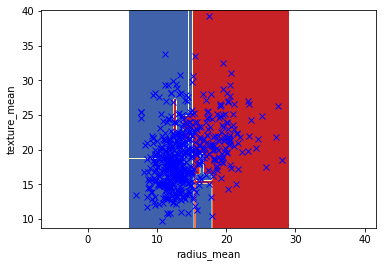

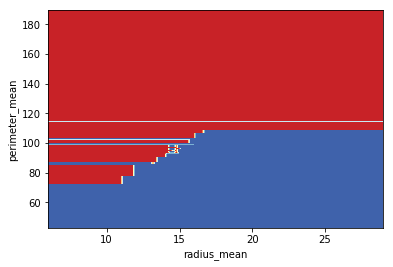

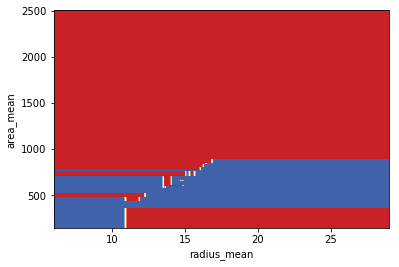

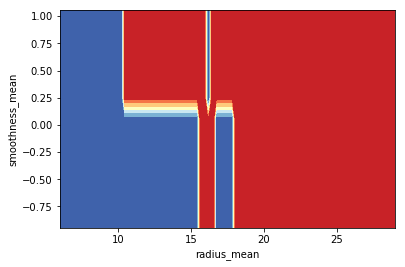

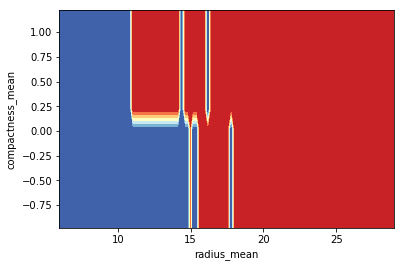

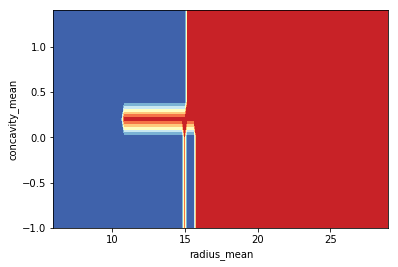

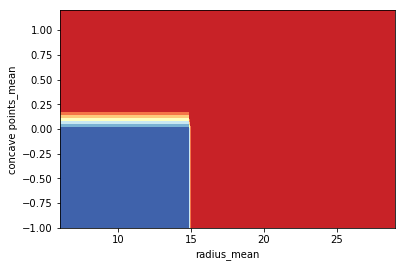

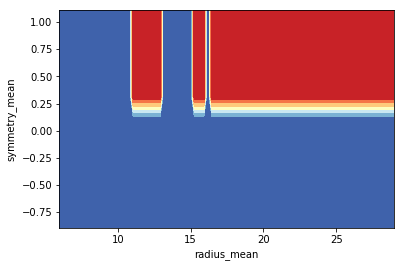

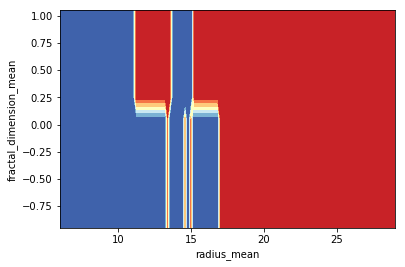

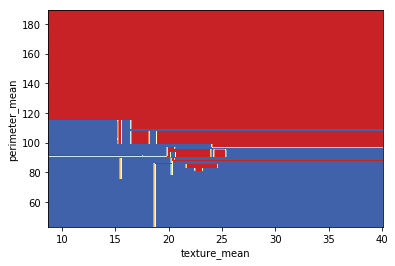

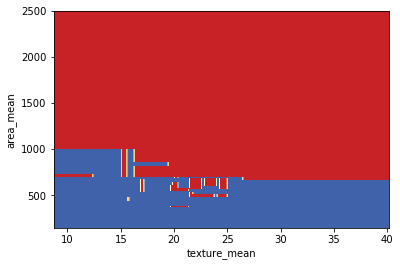

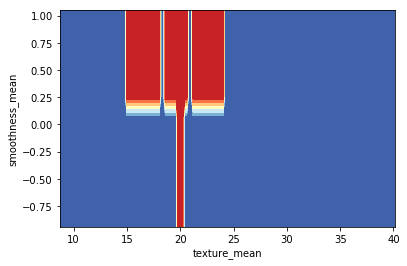

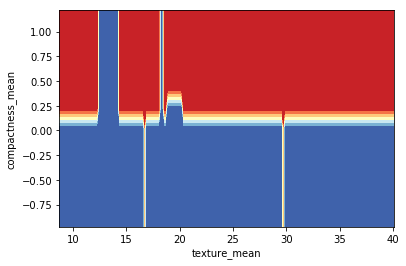

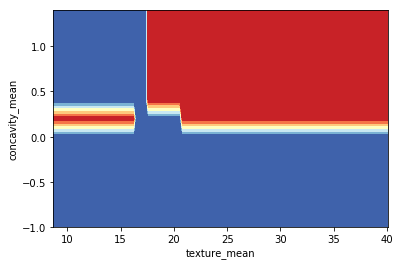

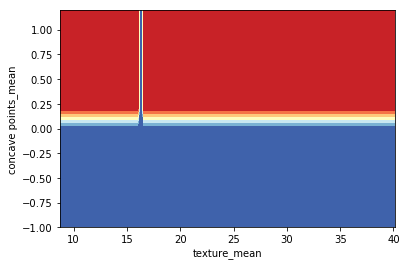

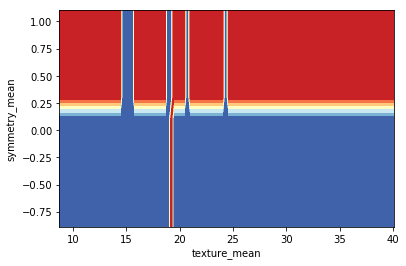

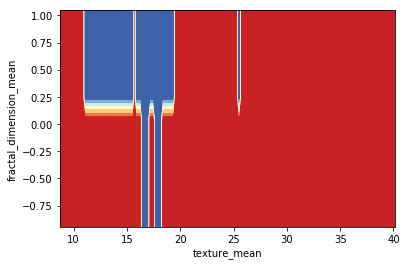

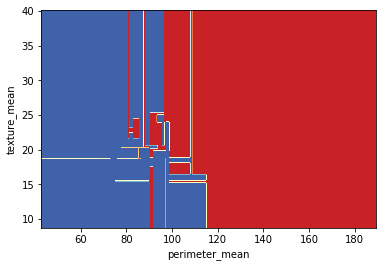

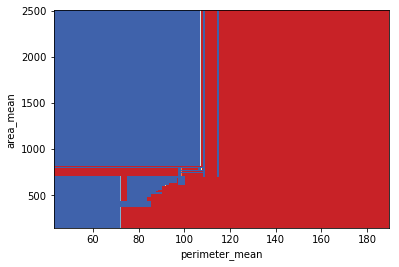

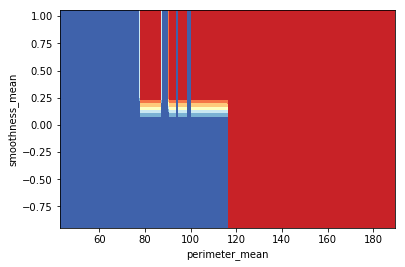

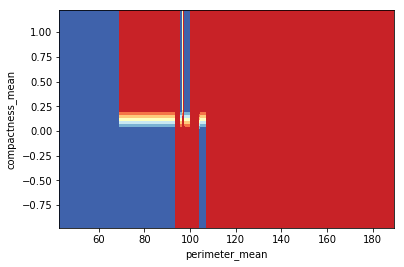

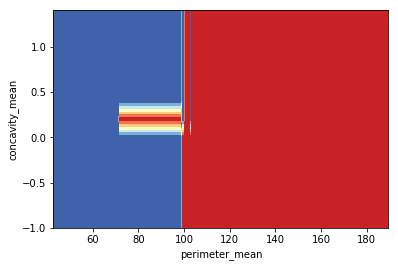

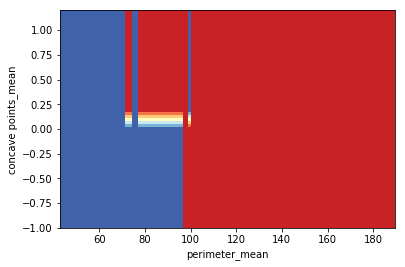

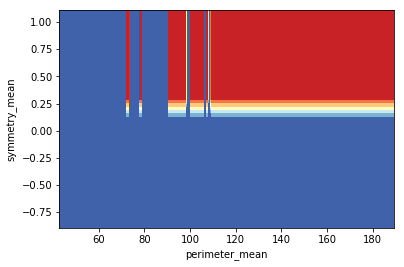

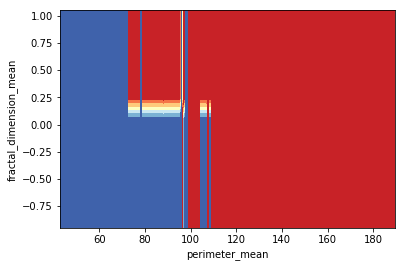

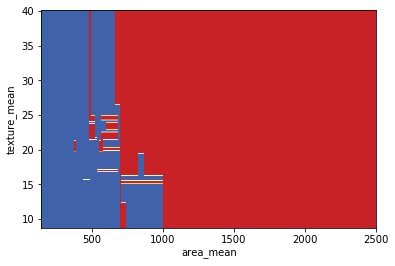

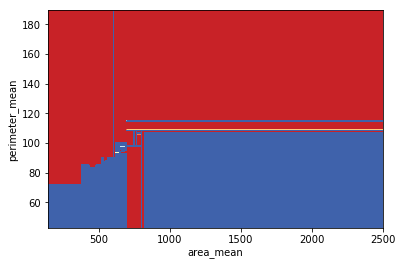

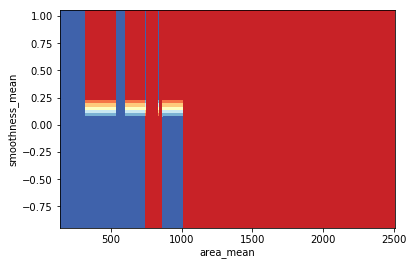

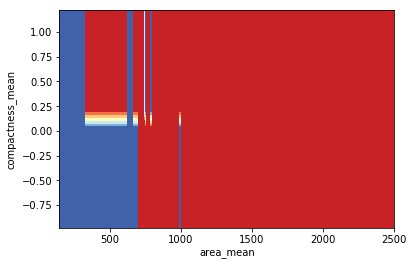

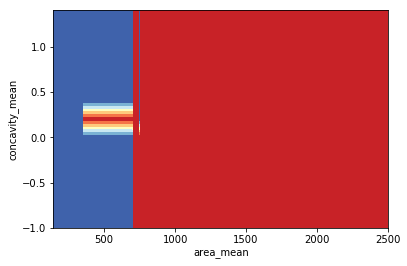

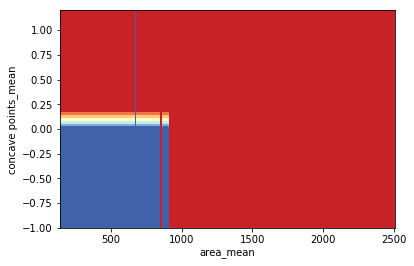

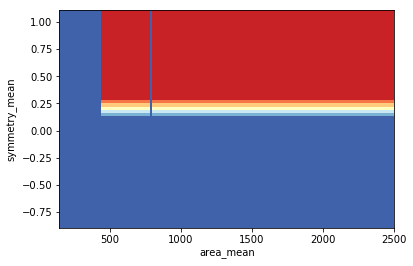

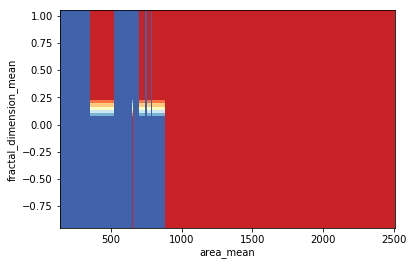

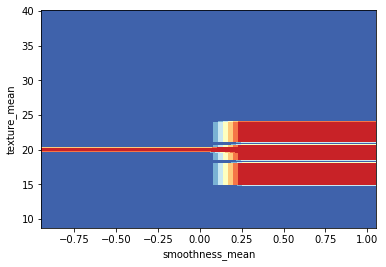

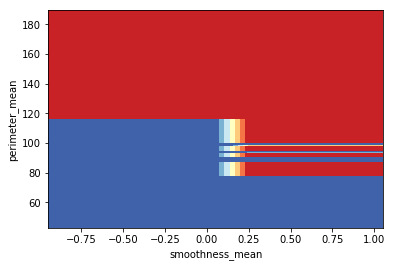

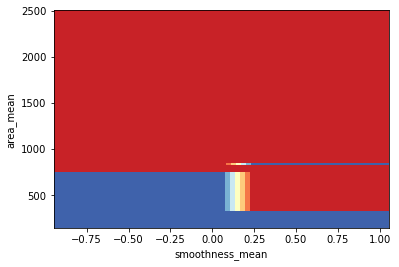

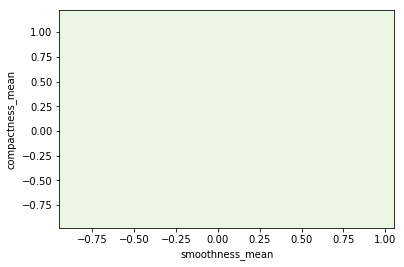

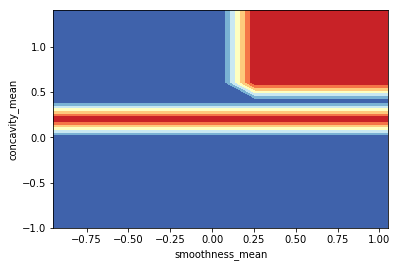

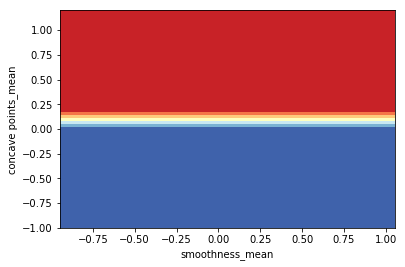

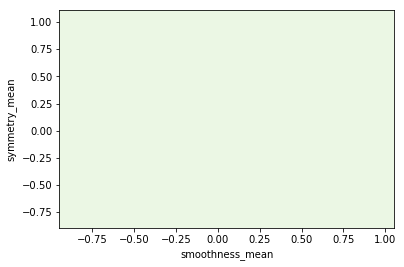

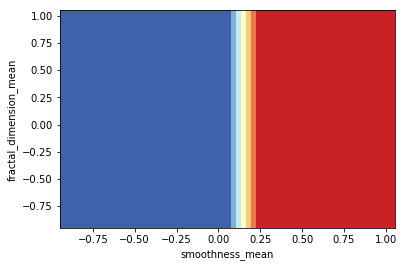

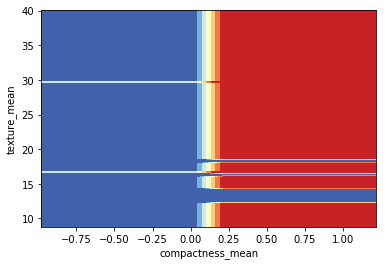

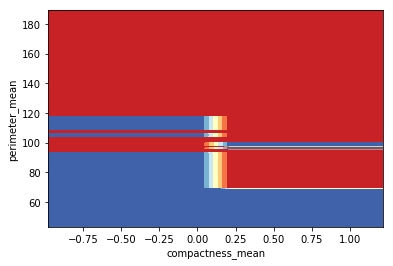

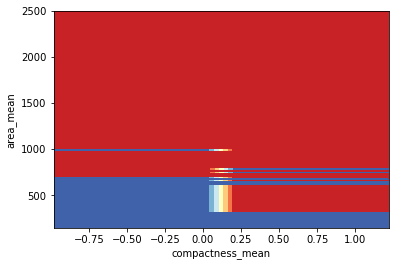

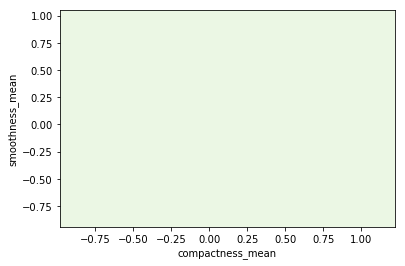

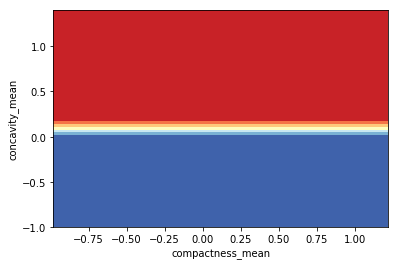

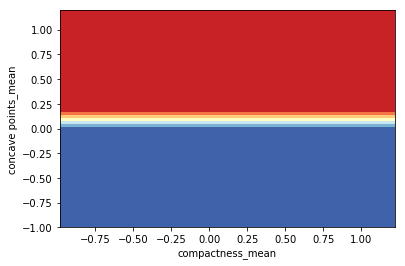

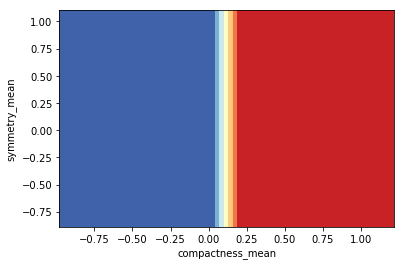

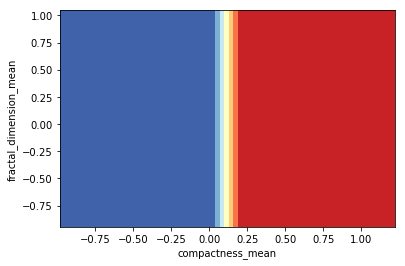

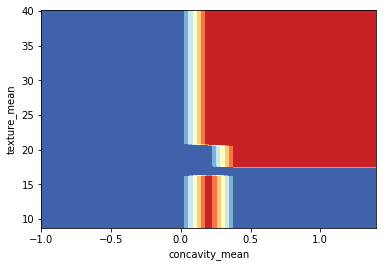

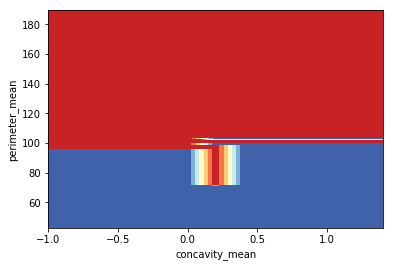

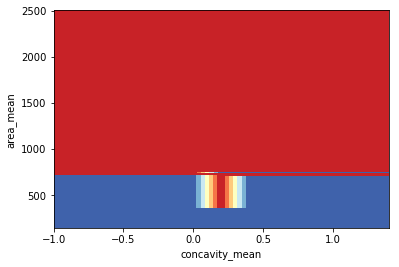

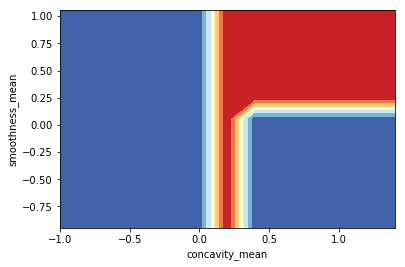

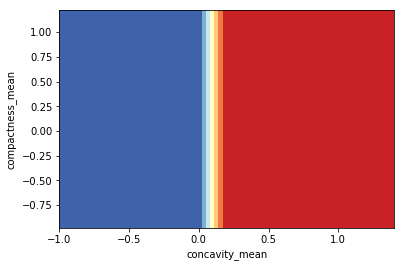

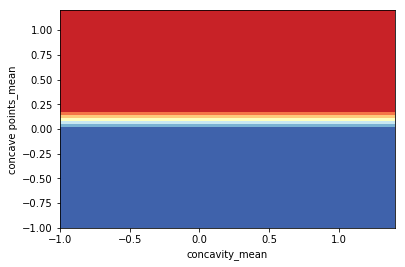

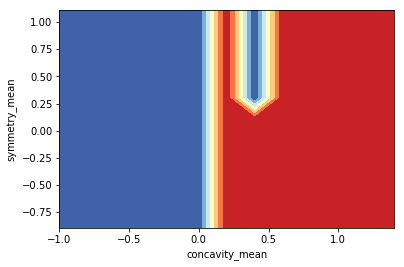

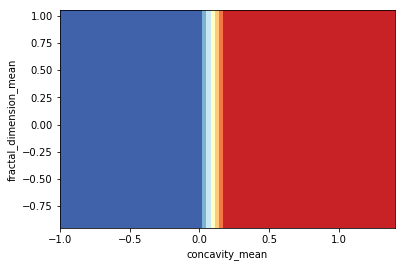

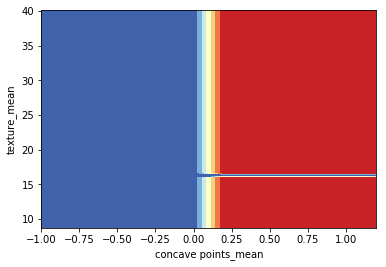

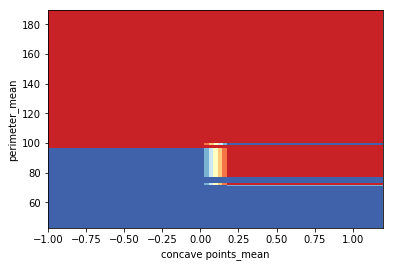

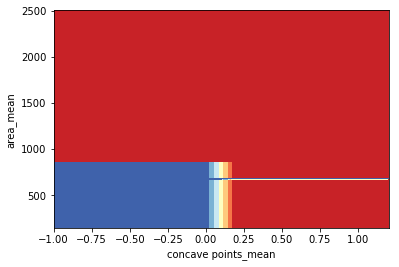

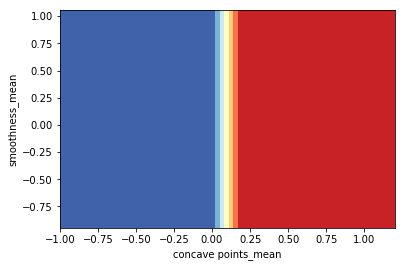

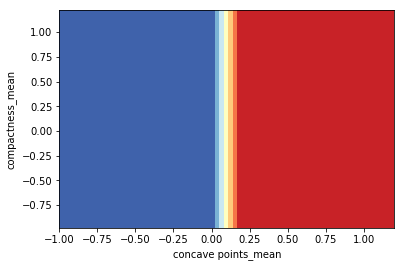

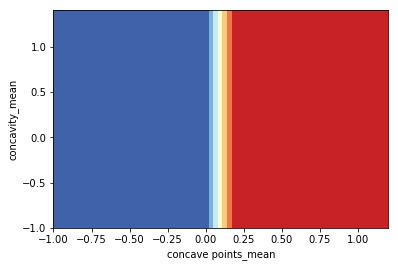

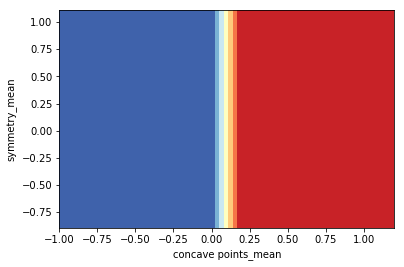

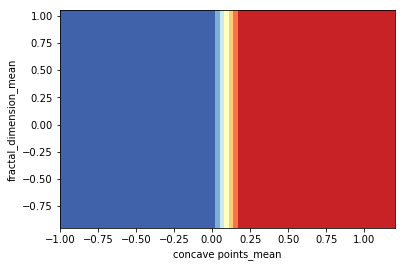

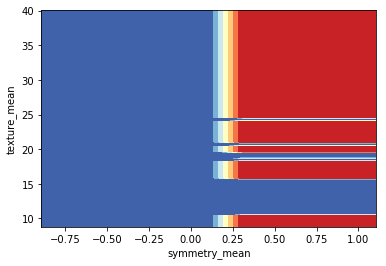

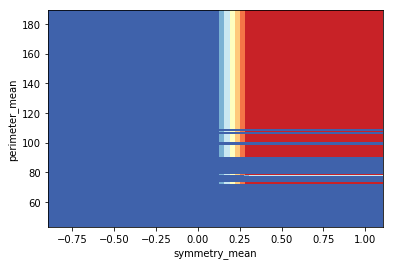

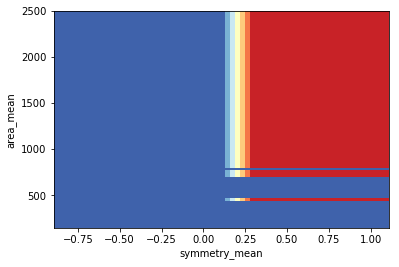

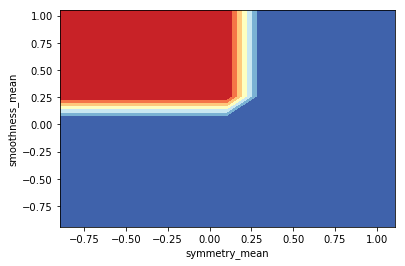

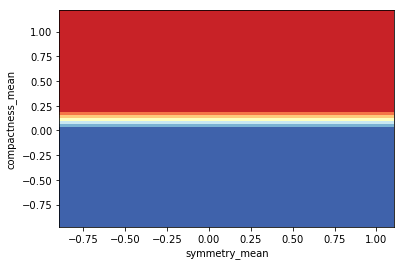

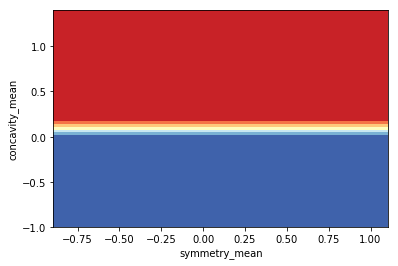

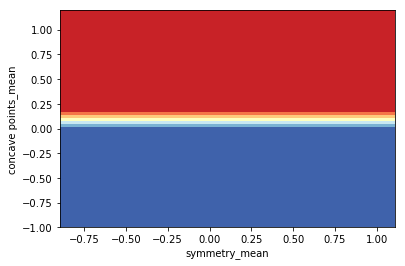

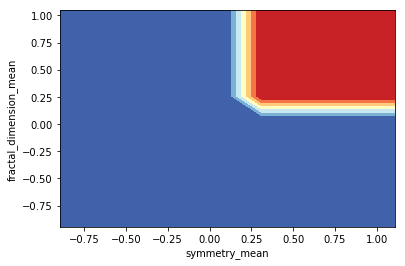

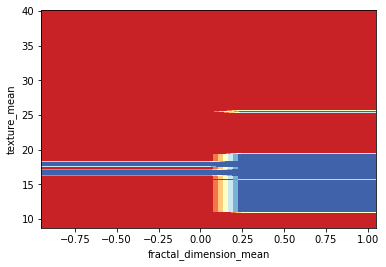

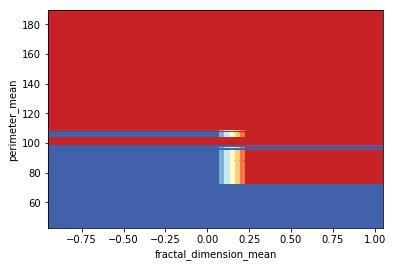

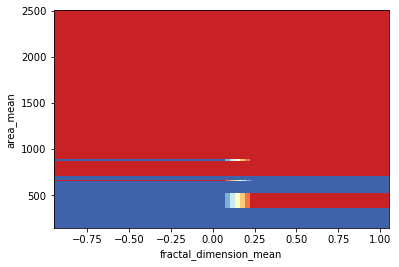

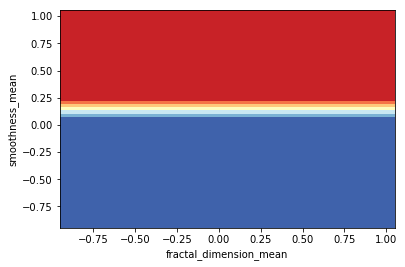

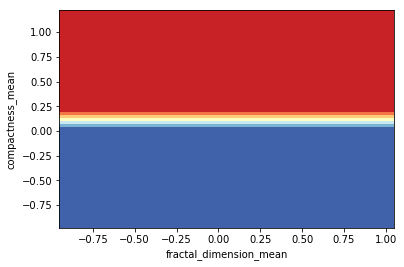

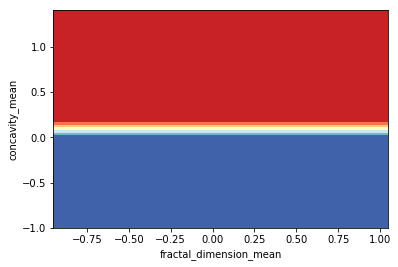

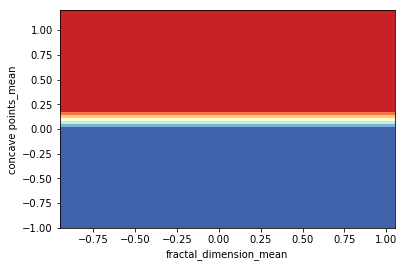

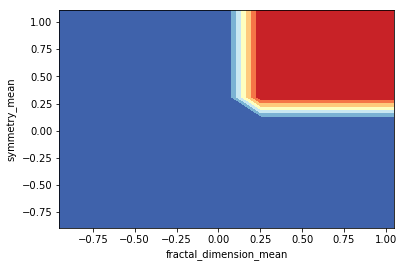

Total time: 16.7220001221
end


In [211]:
import time
#very slow - plot_step = 0.08 and 6 pair-wise plots takes ~ 20 sec
#to-do add more pairwise plots between different attributes. 
#n*(n-1)/2 = 496 possible pairwise graphs - down to 243 if attributes aren't plotted against themselves. 
print("start")
print(attributeNames)

n_classes = 2
plot_colors = "ryb"
plot_step = 0.2
start_time = time.time()
loop_count = 0
graph_pair_original = [[0, 1], [0, 2], [0, 3],[1, 2], [1, 3], [2,3]]

for pairidx, pair in enumerate(graph_pair):  
    #print "pairidx: " + str(pairidx) + " " + "pair: " + str(pair)
    # We only take the two corresponding features
    X = X_list[:, pair]
    y = y_list

    # Train
    clf = tree.DecisionTreeClassifier().fit(X, y)

    # Plot the decision boundary
    #plt.subplot(2, 3, pairidx + 1)
    #plt.subplot(9, 9, pairidx+1)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    #plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    plt.xlabel(attributeNames[pair[0]])
    plt.ylabel(attributeNames[pair[1]])
    #plt.savefig('Decision_tree_plots/plot' + str(loop_count) + '.png')
    plt.show()
    loop_count = loop_count + 1
    #print(str(time.time() - start_time) + " time for " + str(loop_count) + " loops")

#plt.suptitle("Decision surface of a decision tree using paired features")
#plt.legend(loc='lower right', borderpad=0, handletextpad=0)
#plt.axis("tight")
#plt.show()

time_taken = (time.time() - start_time)
print "Total time: " + str(time_taken)
print("end")



## 1.6 

Here we try to plot a ROC curve for an AUC graph. 

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

#I can't get the correct shape for true_class_lable and pred to be accpted in the roc_curve() func.

#write your code here

aucs = []

#Here we make our y_list into a nested list again.
y_list_roc = []
for j in raw_data['diagnosis']:
    y_list_roc.append([j])
    

true_class_label = y_list_roc
pred1 = X_list

#print pred1
#print "len pred1: " + str(len(pred1))
#print true_class_label
#print "len true_class_label: " + str(len(true_class_label))

#Predictor 1 --------------
fpr, tpr, thresholds = roc_curve(true_class_label, pred1)
roc_auc = auc(fpr, tpr)
aucs.append(roc_auc)
print(fpr)
print(tpr)
print(thresholds)

#Predictor 2 --------------
fpr2, tpr2, thresholds2 = roc_curve(true_class_label, pred2)
roc_auc2 = auc(fpr2, tpr2)
aucs.append(roc_auc2)

#Plot ---------------------
plt.figure()
lw = 2 #linewidth
plt.plot(fpr, tpr, color='darkorange', lw=lw, label = 'ROC curve pred1 (AUC = %0.2f)' % (aucs[0]))
plt.plot(fpr2, tpr2, color='darkred', lw=lw, label = 'ROC curve pred2 (AUC = %0.2f)' % (aucs[1]))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label = 'random guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

print('Both classifiers work better than random guessing')

# Scrap code below:

In [ ]:

##List flattener
flat_list = [item for sublist in list_to_flatten for item in sublist]


## Part 2 Support Vector Machine
For the most part our data is already preprocessed, so besides some minor changes that may be needed for this new algorithms it should already be fine.   

We use 3 kernels, ie. classification functions.  

1) First we can use parameter tuning to find roughly the best parameters for each kernel type.  
2) Next we run SVM models for a number of different conditions: kernel type, data-split type, parameter type.  
3-4) Then we will extract the most and least important features and plot them.  
5) We re run our decision tree without the poorest attributes.

Then when we know which features are the least important we can go back to our decision tree with these attributes removed and see if there is any increase in its precision.

## 2.1

In [129]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm

def svc_param_selection(X, y, nfolds, k = 'rbf'):
    Cs = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 9, 10, 11]
    gammas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
    coef0s = [0.001 , 0.01, 0.1, 0.5, 1, 5, 10]
    param_grid = {'C': Cs, 'gamma' : gammas}
    param_grid_linear = {'C': Cs}
    param_grid_sigmoid = {'C': Cs, 'coef0' : coef0s}
    if k == 'linear':
        grid_search = GridSearchCV(svm.SVC(kernel='linear'), param_grid_linear, cv=nfolds)
    elif k == 'sigmoid':
        grid_search = GridSearchCV(svm.SVC(kernel='sigmoid'), param_grid_sigmoid, cv=nfolds)
    elif k == 'rbf':
        grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=nfolds)
    else:
        print "Invalid kernel."
        return;
    grid_search.fit(X_list, y_list)
    #grid_search.best_params_
    print grid_search.best_params_
    return

print "linear kernel optimal parameters: "
svc_param_selection(X_list, y_list, 5, k = 'linear')
print "rbf kernel optimal parameters: "
svc_param_selection(X_list, y_list, 5, k = 'rbf')
print "sigmoid kernel optimal parameters: "
svc_param_selection(X_list, y_list, 5, k = 'sigmoid')



linear kernel optimal parameters: 
{'C': 10}
rbf kernel optimal parameters: 
{'C': 0.5, 'gamma': 0.001}
sigmoid kernel optimal parameters: 
{'C': 0.001, 'coef0': 0.001}


## 2.2

In [130]:
#linear kernel optimal parameters: 
#{'C': 10}
#rbf kernel optimal parameters: 
#{'C': 0.5, 'gamma': 0.001}
#sigmoid kernel optimal parameters: 
#{'C': 0.001, 'gamma': 0.001}


from sklearn import svm

start_time = time.time()

kernel_types = ['rbf', 'linear', 'sigmoid']
#poly kernel doesn't work, neither does precomputed. 
    
X_train,X_test,y_train,y_test = train_test_split(X_list,y_list,test_size=0.25,random_state=42)
  
print 'Using all the data to train and then test:'
for i in range(0, len(kernel_types)):
    clf = svm.SVC(kernel = kernel_types[i], C= 1.0,probability=False,gamma = 'auto')
    clf.fit(X_list,y_list)
    prediction = clf.predict(X_list)
    #print prediction
    print ' score of svm model with kernel: ' + kernel_types[i] + ': ' + str(clf.score(X_list,y_list))
    #plt.clf()
    #plt.scatter(X[:, 0], X[:, 1], c=y, zorder=10, cmap=plt.cm.Paired, edgecolor='k', s=20)
    #plt.show()
   
print '\nUsing cross-validation:'
for i in range(0, len(kernel_types)):
    clf = svm.SVC(kernel = kernel_types[i], C= 1.0,probability=False, gamma = 'auto')
    clf.fit(X_train,y_train)
    prediction = clf.predict(X_test)
    #print prediction
    print ' score of svm model with kernel: ' + kernel_types[i] + ': ' + str(clf.score(X_test,y_test))
    #plt.clf()
    #plt.scatter(X[:, 0], X[:, 1], c=y, zorder=10, cmap=plt.cm.Paired, edgecolor='k', s=20)
    #plt.scatter(X_test[:, 0], X_test[:, 1], s=80, facecolors='none',zorder=10, edgecolor='k')
    #plt.show()
print '\nUsing cross-validation and optimized parameters:'
for i in range(0, len(kernel_types)):
    #clf = svm.SVC(kernel = kernel_types[i], C= 1.0,probability=False, gamma = 'auto')
    if kernel_types[i] == 'linear':
        clf = svm.SVC(kernel = 'linear', C= 10.0, probability=False, gamma = 'auto')
    elif kernel_types[i] == 'rbf':
        clf = svm.SVC(kernel = 'rbf', C= 0.5, probability=False, gamma = 0.001)
    elif kernel_types[i] == 'sigmoid':
        clf = svm.SVC(kernel = 'sigmoid', C= 0.001, probability=False, gamma = 0.001, coef0 = 0.001)
    clf.fit(X_train,y_train)
    prediction = clf.predict(X_test)
    #print prediction
    print ' score of svm model with kernel: ' + kernel_types[i] + ': ' + str(clf.score(X_test,y_test))
    #plt.clf()
    #plt.scatter(X[:, 0], X[:, 1], c=y, zorder=10, cmap=plt.cm.Paired, edgecolor='k', s=20)
    #plt.scatter(X_test[:, 0], X_test[:, 1], s=80, facecolors='none',zorder=10, edgecolor='k')
    #plt.show()

print "\nExecution time: " + str(time.time() - start_time)

#Counts the number of predictions for each class.
def score_function():
    sum_m = 0
    sum_b = 0
    for i in range(0,len(prediction)):
        if prediction[i] == 0:
            sum_m += 1
        elif prediction[i] == 1:
            sum_b += 1
        else:
            print "error"
     
    print 'malignant: ' + str(sum_m)
    print 'benign: ' + str(sum_b)


Using all the data to train and then test:
 score of svm model with kernel: rbf: 1.0
 score of svm model with kernel: linear: 0.966608084359
 score of svm model with kernel: sigmoid: 0.627416520211

Using cross-validation:
 score of svm model with kernel: rbf: 0.622377622378
 score of svm model with kernel: linear: 0.958041958042
 score of svm model with kernel: sigmoid: 0.622377622378

Using cross-validation and optimized parameters:
 score of svm model with kernel: rbf: 0.909090909091
 score of svm model with kernel: linear: 0.965034965035
 score of svm model with kernel: sigmoid: 0.622377622378

Execution time: 3.23300004005


## 2.3

31
[u'area_mean', u'area_se', u'area_worst', u'compactness_mean', u'compactness_se', u'compactness_worst', u'concave', u'concavity_mean', u'concavity_se', u'concavity_worst', u'fractal_dimension_mean', u'fractal_dimension_se', u'fractal_dimension_worst', u'perimeter_mean', u'perimeter_se', u'perimeter_worst', u'points_mean', u'points_se', u'points_worst', u'radius_mean', u'radius_se', u'radius_worst', u'smoothness_mean', u'smoothness_se', u'smoothness_worst', u'symmetry_mean', u'symmetry_se', u'symmetry_worst', u'texture_mean', u'texture_se', u'texture_worst']


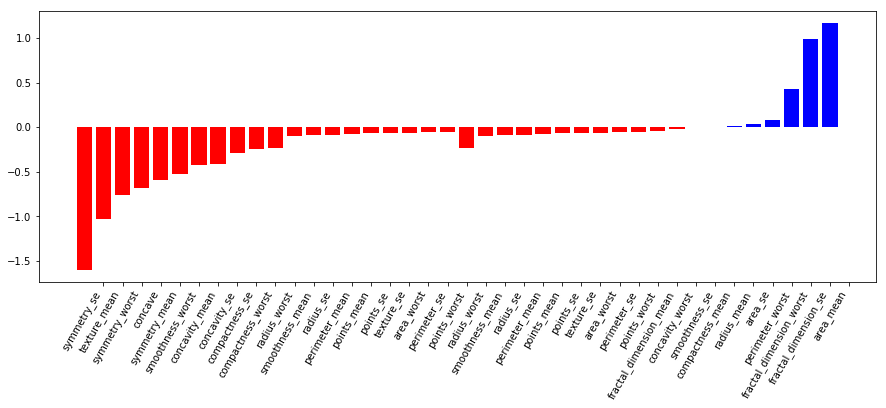

In [131]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm

def plot_coefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()
    
cv = CountVectorizer()
cv.fit(attributeNames)
print len(cv.vocabulary_)
print cv.get_feature_names()
X_train = cv.transform(attributeNames)


svm = svm.SVC(kernel = 'linear')
svm.fit(X_list, y_list)
plot_coefficients(svm, cv.get_feature_names())

## 2.4

30
[False False False False False False False False False False False False
 False False False False False False False False False False False False
  True  True  True  True  True False]
[ 4 17 12 26  9  8  5  6  7 23 21  2 10 18 19 15 14 16 24 22  3 11 20 25  1
  1  1  1  1 13]
The 25 worst attributes are: 

radius_mean             4
texture_mean           17
perimeter_mean         12
area_mean              26
smoothness_mean         9
compactness_mean        8
concavity_mean          5
concave points_mean     6
symmetry_mean           7
fractal_dimension_mean 23
radius_se              21
texture_se              2
perimeter_se           10
area_se                18
smoothness_se          19
compactness_se         15
concavity_se           14
concave points_se      16
symmetry_se            24
fractal_dimension_se   22
radius_worst            3
texture_worst          11
perimeter_worst        20
area_worst             25
fractal_dimension_worst 13

Top 5 attributes
smoothness_worst
com

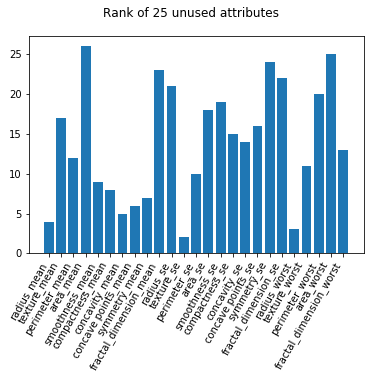

In [227]:
from sklearn.feature_selection import RFE
from sklearn import svm
import sys

svm = svm.SVC(kernel = 'linear')
print len(attributeNames)

n_attributes = 5 #the top n attributes, ie. selects the best 20 attributes. 
rfe = RFE(svm, n_attributes)
rfe = rfe.fit(X_list, y_list)

print(rfe.support_)
print(rfe.ranking_)

worst_feature_names = []
worst_feature_ranks = []


print "The " + str(30-n_attributes) + " worst attributes are: \n"
for i in range(0, len(attributeNames)):
    if rfe.ranking_[i] != 1:
        #print str(attributeNames[i]) + "  " + str(rfe.ranking_[i]) 
        worst_feature_names.append(attributeNames[i])
        worst_feature_ranks.append(rfe.ranking_[i])
        print '{0:22s} {1:2d}'.format(attributeNames[i], rfe.ranking_[i])

print "\nTop " + str(n_attributes) + " attributes"
top_n_attributes = []
for i in range(0, len(attributeNames)):
    if rfe.ranking_[i] == 1:
        top_n_attributes.append(attributeNames[i])
        print attributeNames[i]

#Looking at the ranking_ (low int better) we can see which attributes contribute the least to our classification. 
#Using svc.linear_kernal because using LinearSVC() seems to change more between runs. 

#for i in range(0, len(attributeNames)):
#    if rfe.support_[i] == False:
#        print("\x1b[31m"+attributeNames[i]+"\x1b[0m")
#    else:
#        print attributeNames[i]
height = [i for i in range(0, len(worst_feature_names))]
plt.bar(height, worst_feature_ranks)
plt.xticks(np.arange(0, len(worst_feature_names)), worst_feature_names, rotation=60, ha='right')
plt.suptitle('Rank of ' + str( 30 - n_attributes ) + ' unused attributes')
plt.show()


#5 worst
#smoothness_mean         6
#perimeter_se            3
#perimeter_worst         4
#smoothness_worst        2....
#symmetry_worst          5

#10 worst  --- notice only 1 overlap. 
#texture_mean            2
#area_mean              11
#radius_se               8
#texture_se              6
#smoothness_se           3
#compactness_se          4
#fractal_dimension_se    9
#radius_worst            7
#area_worst              5
#smoothness_worst       10

## 2.5

Here we will re run our decision tree without the features that we determined above.

['smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst']
['smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst']
      |->2  Benign
      |
   |->1 then if concave points_worst =< 0.109549999237: go to 2, else go to 3
   |  |
   |  |->3  Benign
   |
if concave points_worst =< 0.142349988222: go to 1, else go to 4
   |
   |  |->5  Malignant
   |  |
   |->4 else if concave points_worst =< 0.160299986601: go to 5, else go to 6
      |
      |->6  Malignant
<-------->
Tree Depth:  2
Correct classification percentage: 0.919156414763


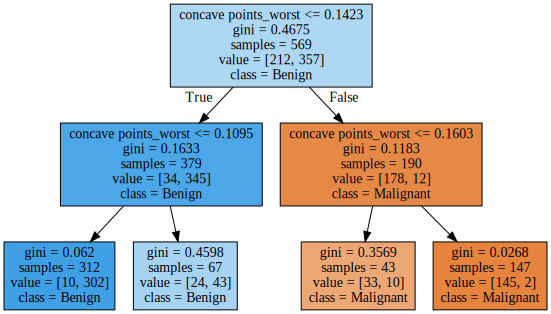

In [252]:
print top_n_attributes
X_optimal = X_raw
#X_optimal = X_optimal.drop(['area_mean'],1)
#X_optimal = X_optimal.drop(['fractal_dimension_mean'],1)
#X_optimal = X_optimal.drop(['symmetry_se'],1)
#X_optimal = X_optimal.drop(['area_worst'],1)
#X_optimal = X_optimal.drop(['fractal_dimension_se'],1)

#X_optimal = X_optimal.drop(['texture_mean'],1)
#X_optimal = X_optimal.drop(['perimeter_mean'],1)
#X_optimal = X_optimal.drop(['smoothness_mean'],1)
#X_optimal = X_optimal.drop(['texture_se'],1)
#X_optimal = X_optimal.drop(['perimeter_se'],1)
#X_optimal = X_optimal.drop(['compactness_se'],1)
#X_optimal = X_optimal.drop(['concavity_se'],1)
#X_optimal = X_optimal.drop(['concave points_se'],1)
#X_optimal = X_optimal.drop(['radius_worst'],1)
#X_optimal = X_optimal.drop(['texture_worst'],1)
#X_optimal = X_optimal.drop(['perimeter_worst'],1)
#X_optimal = X_optimal.drop(['smoothness_worst'],1)
#X_optimal = X_optimal.drop(['concave points_worst'],1)
#X_optimal = X_optimal.drop(['symmetry_worst'],1)
for x in range(0, len(attributeNames)):
    if attributeNames[x] not in top_n_attributes:
        X_optimal = X_optimal.drop([attributeNames[x]],1)

X_optimal_matrix = X_optimal.as_matrix()


attributeNames = [i for i in X_optimal.keys()]#[2:32]
print attributeNames

clf = tree.DecisionTreeClassifier(criterion = 'gini', min_samples_split = 2, max_depth = 2)
clf = clf.fit(X_optimal_matrix,y_list)

score = clf.score(X_optimal_matrix, y_list, sample_weight=None)
tree_print(clf, attributeNames, classNames)

print('Correct classification percentage: ' + str(score))

from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(clf, out_file=None, \
                           feature_names = attributeNames, class_names = classNames, \
                          filled = True)
graph = graphviz.Source(dot_data)
#graph.render("cancer_tree")
graph

depth - correct classification % train - correct classification % test
2 - 0.946009389671 - 0.916083916084
3 - 0.971830985915 - 0.958041958042
4 - 0.995305164319 - 0.951048951049
5 - 0.995305164319 - 0.951048951049
6 - 0.99765258216 - 0.944055944056
7 - 1.0 - 0.951048951049
8 - 1.0 - 0.944055944056
9 - 1.0 - 0.958041958042
10 - 1.0 - 0.944055944056
11 - 1.0 - 0.944055944056
12 - 1.0 - 0.937062937063
13 - 1.0 - 0.944055944056
14 - 1.0 - 0.958041958042
15 - 1.0 - 0.944055944056
16 - 1.0 - 0.944055944056
17 - 1.0 - 0.944055944056
18 - 1.0 - 0.951048951049
19 - 1.0 - 0.951048951049
Max correct classification: 0.958041958042
Min correct classification: 0.916083916084


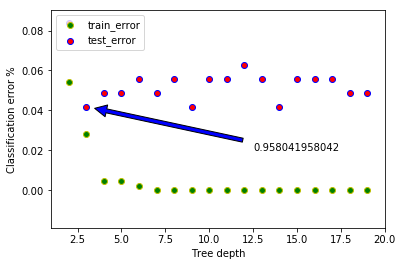

In [249]:
X_train,X_test,y_train,y_test = train_test_split(X_optimal_matrix,y_list,test_size=0.25,random_state=42)

train_error = []
test_error = []

depth = 20

print("depth - correct classification % train - correct classification % test")
for i in range(2,depth):
    clf = tree.DecisionTreeClassifier(criterion = 'gini', max_depth = i, min_samples_split= 2)
    clf = clf.fit(X_train,y_train)
    predictions = clf.predict(X_test)
    x = clf.score(X_train,y_train,sample_weight = None)
    y = clf.score(X_test, y_test, sample_weight = None)
    train_error.append(1-x)
    test_error.append(1-y)
    print(str(i) + ' - ' + str(x) + ' - ' + str(y))
    
print "Max correct classification: " + str(1 - np.min(test_error)) + "\nMin correct classification: " + str(1 - np.max(test_error))
    
plt.scatter(range(2,depth), train_error, c = 'g', edgecolors = 'y', marker = 'o', label="train_error")
plt.scatter(range(2,depth), test_error, c = 'r', edgecolors = 'b', marker = 'o', label="test_error")
plt.xlabel("Tree depth")
plt.ylabel("Classification error %")
plt.annotate(str(1-np.min(test_error)), xy=((test_error.index(np.min(test_error))+2),\
             np.min(test_error)), xytext=(12.5, 0.02),\
             arrowprops=dict(facecolor='blue', shrink=0.05),)
plt.legend(loc=2)
plt.show()

## 3
SVM graph - http://scikit-learn.org/stable/auto_examples/svm/plot_weighted_samples.html#sphx-glr-auto-examples-svm-plot-weighted-samples-py  
SVM graph - http://scikit-learn.org/stable/auto_examples/svm/plot_svm_kernels.html#sphx-glr-auto-examples-svm-plot-svm-kernels-py  
Feature importance graph using gradient boosting - http://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html#sphx-glr-auto-examples-ensemble-plot-gradient-boosting-regression-py

In [100]:
# figure number
fignum = 1

X = np.c_[(.4, -.7),
          (-1.5, -1),
          (-1.4, -.9),
          (-1.3, -1.2),
          (-1.1, -.2),
          (-1.2, -.4),
          (-.5, 1.2),
          (-1.5, 2.1),
          (1, 1),
          # --
          (1.3, .8),
          (1.2, .5),
          (.2, -2),
          (.5, -2.4),
          (.2, -2.3),
          (0, -2.7),
          (1.3, 2.1)].T
y = [0] * 8 + [1] * 8


X = X_list
y = y_list


#print X.shape[1]


# fit the model
for kernel in ('linear', 'poly', 'rbf'):
    clf = svm.SVC(kernel=kernel, gamma=2)
    clf.fit(X, y)

    # plot the line, the points, and the nearest vectors to the plane
    plt.figure(fignum, figsize=(4, 3))
    plt.clf()
    
    plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=80, facecolors='none', zorder=10, edgecolors='k')
    plt.scatter(X[:, 0], X[:, 1], c=y, zorder=10, cmap=plt.cm.Paired,edgecolors='k')

    plt.axis('tight')
#     x_min = -3
#     x_max = 3
#     y_min = -3
#     y_max = 3
    x_min = X[:, 0].min()
    x_max = X[:, 0].max()
    y_min = X[:, 1].min()
    y_max = X[:, 1].max()

    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    print XX.shape[1]
    print YY.shape[1]
    print np.c_[XX.ravel(), YY.ravel()]
    Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
    plt.figure(fignum, figsize=(4, 3))
    plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
    plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
                levels=[-.5, 0, .5])

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    plt.xticks(())
    plt.yticks(())
    fignum = fignum + 1
plt.show()


200
200
[[  6.981        9.71      ]
 [  6.981        9.85859296]
 [  6.981       10.00718593]
 ..., 
 [ 28.11        38.98281407]
 [ 28.11        39.13140704]
 [ 28.11        39.28      ]]


ValueError: X.shape[1] = 2 should be equal to 30, the number of features at training time

### Expectation Maximization 
Below we will try to implement the EM algorithm on our data, this algorithm works with Gaussian Mixture Models (relation to asociation rules).



In [121]:
from sklearn.mixture import GaussianMixture


X_list #train data.

X_train_EM = X_list[:,0] , X_list[:,1]


#for i in range(0,9):
    #plt.plot(X_list[:,i], X_list[:,i+1], 'bx')
    #plt.axis('equal')
    #plt.show()

#plt.plot(X_list[:,0], X_list[:,1], 'bx')
#plt.axis('equal')
#plt.show()
#plt.plot(X_list[:,2], X_list[:,3], 'rx')
#plt.axis('equal')
#plt.show()

gmm = GaussianMixture(n_components=2)
gmm.fit(X_train_EM)
#print(gmm.means_)
#print('\n')
#print(gmm.covariances_)


X, Y = np.meshgrid(np.linspace(-1, 6, num = 30), np.linspace(-1,6, num = 30))

XX = np.array([X.ravel(), Y.ravel()]).T
print XX
Z = gmm.score_samples(XX)
Z = Z.reshape((50,50))
 
plt.contour(X, Y, Z)
plt.scatter(X_train_EM[:, 0], X_train_EM[:, 1])
 
plt.show()

[[-1.         -1.        ]
 [-0.75862069 -1.        ]
 [-0.51724138 -1.        ]
 ..., 
 [ 5.51724138  6.        ]
 [ 5.75862069  6.        ]
 [ 6.          6.        ]]


ValueError: Expected the input data X have 569 features, but got 2 features